In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import momepy
from shapely.geometry import Polygon

# Input parameters
Name = 'Imredd'
xMin = 7.17
xMax = 7.22
yMin = 43.7
yMax = 43.65
projected_crs = 'EPSG:2154'

# Create bounding box polygon
lon_point_list = [xMin, xMax, xMax, xMin]
lat_point_list = [yMax, yMax, yMin, yMin]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

# Output Geopackage name
gpkg = f'SDM24_{Name}_raw.gpkg'

# Function to clean data
def clean_geodataframe(gdf):
    # Keep only polygon geometries
    gdf = gdf[gdf.geometry.type == 'Polygon']
    # Drop columns with list values
    list_columns = [col for col in gdf.columns if gdf[col].apply(lambda x: isinstance(x, list)).any()]
    gdf = gdf.drop(columns=list_columns, errors='ignore')
    return gdf

# **Step 1: Download and process OSM building data**
print("Step 1: Downloading OSM buildings.")
buildings = ox.features.features_from_polygon(polygon['geometry'][0], tags={'building': True})

# Clean buildings data
print("Cleaning buildings data.")
buildings = clean_geodataframe(buildings)
buildings = buildings.to_crs(projected_crs)

# Save buildings to Geopackage
buildings.to_file(gpkg, layer='osm_all_buildings', driver="GPKG")

# **Step 2: Download and process OSM street data**
print("Step 2: Downloading OSM streets.")
# Extract the streets based on the bounding box
G = ox.graph_from_polygon(polygon['geometry'][0], network_type='all')

# Convert graph to GeoDataFrame
print("Step 2.1: Converting streets graph to GeoDataFrame.")
linestrings_df = ox.convert.graph_to_gdfs(G)
linestrings_df = linestrings_df[1]
linestrings_gdf = gpd.GeoDataFrame(linestrings_df, geometry='geometry')

# Function to convert lists to strings
def convert_list_to_string(val):
    if isinstance(val, list):
        return ', '.join(map(str, val))
    return val

# Call the above function
print("Step 2.2: Converting lists to strings.")
for column in linestrings_gdf.columns:
    if any(isinstance(val, list) for val in linestrings_gdf[column]):
        linestrings_gdf[column] = linestrings_gdf[column].apply(convert_list_to_string)

# Keep essential columns only if they exist
essential_columns = ['geometry', 'osmid', 'highway','oneway','maxspeed','reversed','lanes','width','access','service','tunnel','bridge','junction']
existing_columns = linestrings_gdf.columns.intersection(essential_columns)
linestrings_gdf = linestrings_gdf.loc[:, existing_columns]

linestrings_gdf = linestrings_gdf.to_crs(projected_crs)
linestrings_gdf.to_file(gpkg, layer='osm_all_streets', driver="GPKG")

# **Step 3: Download and process OSM Points of Interest (POIs)**
print("Step 3: Downloading OSM POIs.")
poi = ox.features.features_from_polygon(polygon['geometry'][0], tags={'amenity': True, 'shop': True, 'tourism': True})

# Clean POI data
print("Cleaning POI data.")
poi = poi[poi.geometry.type == 'Point']  # Keep only point geometries
poi = poi.to_crs(projected_crs)

# Save POI to Geopackage
poi.to_file(gpkg, layer='osm_poi', driver="GPKG")
print("POI data saved.")
print("Process complete. Raw OSM data saved.")

# **Step 4: Filter and retain relevant building columns**
# Load the osm_all_buildings layer
buildings = gpd.read_file("SDM24_Imredd_raw.gpkg", layer="osm_all_buildings")

# Retain only columns 'height', 'building', and geometry
columns_to_keep = ['height', 'building', 'geometry', 'building:levels']
filtered_buildings = buildings[columns_to_keep]

# Verify the result
print(filtered_buildings.head())

# Save filtered data
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# The rest of the steps follow the same structure and logic as above, focusing on processing streets, POIs, calculating indicators, and performing machine learning tasks.

# **Step 5: Filter and retain relevant street columns**
# Load the osm_all_streets layer
streets = gpd.read_file("SDM24_Imredd_raw.gpkg", layer="osm_all_streets")

# Retain only the desired columns and geometry
columns_to_keep = ['highway', 'maxspeed', 'oneway', 'service', 'geometry']
filtered_streets = streets[columns_to_keep]

# Verify the data
print(filtered_streets.head())

# Save the filtered streets in the existing GeoPackage
filtered_streets.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_streets", driver="GPKG")

# **Step 6: Filter and retain relevant POI columns**
# Load the osm_poi layer
poi = gpd.read_file("SDM24_Imredd_raw.gpkg", layer="osm_poi")

# Retain only the desired columns and geometry
columns_to_keep = ['amenity', 'name', 'shop', 'cuisine', 'geometry']
filtered_poi = poi[columns_to_keep]

# Verify the data
print(filtered_poi.head())

# Save the filtered POI data in the existing GeoPackage
filtered_poi.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_poi", driver="GPKG")

# **Step 7: Calculate building surface area**
# Ensure projection is in metric units (e.g., EPSG:2154 for France)
if filtered_buildings.crs.is_geographic:
    filtered_buildings = filtered_buildings.to_crs(epsg=2154)

# Calculate surface area in square meters
filtered_buildings['surface_m2'] = filtered_buildings.geometry.area

# Verify the results
print(filtered_buildings[['height', 'building', 'surface_m2']].head())

# Save data with the new column
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# **Step 8: Calculate convexity of buildings**
filtered_buildings['convex'] = momepy.convexity(filtered_buildings)

# Verify results
print(filtered_buildings[['height', 'building', 'surface_m2', 'convex']].head())

# Save data with the new column
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# **Step 9: Calculate elongation of buildings**
filtered_buildings['elong'] = momepy.elongation(filtered_buildings)

# Verify results
print(filtered_buildings[['height', 'building', 'surface_m2', 'convex', 'elong']].head())

# Save data with the new column
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# **Step 10: Count POIs within 10m buffer around buildings**
# Create 10m buffers around buildings
filtered_buildings["buffer"] = filtered_buildings.geometry.buffer(10)

# Count POIs within each buffer
counts = []
for buffer_geom in filtered_buildings["buffer"]:
    count = filtered_poi[filtered_poi.geometry.within(buffer_geom)].shape[0]
    counts.append(count)

# Add counts to the GeoDataFrame
filtered_buildings["poi_count_10"] = counts

# Display the results
print(filtered_buildings[["geometry", "poi_count_10"]])

# Drop the buffer column to avoid conflicts
filtered_buildings = filtered_buildings.drop(columns=["buffer"])

# Save data with the new column
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# **Step 11: Count POIs within 400m buffer around buildings**
# Create 400m buffers around buildings
filtered_buildings["buffer"] = filtered_buildings.geometry.buffer(400)

# Count POIs within each buffer
counts = []
for buffer_geom in filtered_buildings["buffer"]:
    count = filtered_poi[filtered_poi.geometry.within(buffer_geom)].shape[0]
    counts.append(count)

# Add counts to the GeoDataFrame
filtered_buildings["poi_count_400"] = counts

# Display the results
print(filtered_buildings[["geometry", "poi_count_400"]])

# Drop the buffer column to avoid conflicts
filtered_buildings = filtered_buildings.drop(columns=["buffer"])

# Save data with the new column
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")

# **Step 12: Calculate soft mobility length within 400m radius**
# Ensure both datasets use the same CRS
if filtered_buildings.crs != filtered_streets.crs:
    filtered_streets = filtered_streets.to_crs(filtered_buildings.crs)

# Define soft mobility street types
soft_mobility_types = ["bridleway", "cycleway", "footway", "living_street", "path", "pedestrian", "footway, steps", "pedestrian, path"]

# Function to calculate soft mobility length within each buffer
def calculate_soft_mobility_length(building_geometry, streets_gdf, mobility_types):
    soft_mobility_streets = streets_gdf[streets_gdf['highway'].isin(mobility_types)]
    buffer = building_geometry.buffer(400)
    streets_in_buffer = soft_mobility_streets[soft_mobility_streets.geometry.intersects(buffer)]
    total_length = streets_in_buffer.geometry.length.sum()
    return total_length

# Apply the function to each building
filtered_buildings["soft_mobility_length_400m"] = filtered_buildings.geometry.apply(
    lambda geom: calculate_soft_mobility_length(geom, filtered_streets, soft_mobility_types)
)

# Save the updated data
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings_with_mobility_length", driver="GPKG")
print("Soft mobility calculation completed and saved.")

# **Step 13: Rename columns for better clarity**
column_rename_mapping = {
    'convex': 'C',
    'elong': 'E',
    'poi_count_10': 'P10',
    'poi_count_400': 'P400',
    'surface_m2': 'S',
    'height': 'H',
    'building:levels': 'FL',
    'building': 'B',
    'soft_mobility_length_400m': 'M',
}

filtered_buildings.rename(columns=column_rename_mapping, inplace=True)

# Verify renaming
print(filtered_buildings.head())

# Ensure numeric conversion for height and building levels
filtered_buildings['H'] = pd.to_numeric(filtered_buildings['H'], errors='coerce')
filtered_buildings['FL'] = pd.to_numeric(filtered_buildings['FL'], errors='coerce')

# **Step 14: Handle missing values in height and building levels**
print("Step 14: Filling missing values for 'height' and 'building:levels'.")

filtered_buildings['H'] = filtered_buildings.apply(
    lambda row: row['FL'] * 3 if pd.isna(row['H']) and not pd.isna(row['FL']) else row['H'],
    axis=1
)

filtered_buildings['FL'] = filtered_buildings.apply(
    lambda row: round(row['H'] / 3) if pd.isna(row['FL']) and not pd.isna(row['H']) else row['FL'],
    axis=1
)

# Save enriched data
filtered_buildings.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings", driver="GPKG")
print("Data enrichment complete.")

# **Step 15: Split data into subsets with and without missing FL values**
# Select relevant columns
columns_to_keep = ['C', 'E', 'P10', 'P400', 'S', 'M', 'FL']
building_filtered = filtered_buildings[columns_to_keep]

# Subsets of data
building_non_null = building_filtered[building_filtered['FL'].notnull()]
building_null = building_filtered[building_filtered['FL'].isnull()]

# **Step 16: Split non-null data into training and testing sets**
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define training ratio
training_ratio = 0.8
np.random.seed(45)
mask = np.random.rand(len(building_non_null)) < training_ratio

# Training and testing datasets
data_train = building_non_null[mask]
data_test = building_non_null[~mask]

# Convert FL (building levels) to categorical type
data_train['FL'] = data_train['FL'].astype('int32').astype('category')
data_test['FL'] = data_test['FL'].astype('int32').astype('category')

# Define explanatory variables (features) and target variable
X_train = data_train.drop(columns=['FL'])
y_train = data_train['FL']
X_test = data_test.drop(columns=['FL'])
y_test = data_test['FL']

# **Step 17: Train a decision tree classifier**
clf = DecisionTreeClassifier(random_state=45)
clf.fit(X_train, y_train)

# Predict on the testing data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy on test data: {accuracy:.2f}")

# **Step 18: Predict FL for all buildings, including those with missing values**
# Define features for prediction
training_features = ['C', 'E', 'P10', 'P400', 'S', 'M']

# Create a new DataFrame for predictions
filtered_buildingsV2 = filtered_buildings[training_features].copy()

# Predict FL for the new dataset
filtered_buildingsV2['FLPRED'] = clf.predict(filtered_buildingsV2[training_features])

# Display the results for verification
print(filtered_buildingsV2.head())

# **Step 19: Merge predictions back into the original GeoDataFrame**
# Ensure the geometry is preserved
if not isinstance(filtered_buildingsV2, gpd.GeoDataFrame):
    filtered_buildingsV2 = gpd.GeoDataFrame(filtered_buildingsV2, geometry=filtered_buildings['geometry'])

# Save the predicted data in the GeoPackage
filtered_buildingsV2.to_file("SDM24_Imredd_filtered.gpkg", layer="filtered_buildings_v2", driver="GPKG")
print("Predictions saved successfully.")


Step 1: Downloading OSM buildings.
Cleaning buildings data.
Step 2: Downloading OSM streets.
Step 2.1: Converting streets graph to GeoDataFrame.
Step 2.2: Converting lists to strings.
Step 3: Downloading OSM POIs.
Cleaning POI data.
POI data saved.
Process complete. Raw OSM data saved.
  height building                                           geometry  \
0   None      yes  POLYGON ((1037242.123 6293415.542, 1037243.252...   
1   None      yes  POLYGON ((1037735.117 6295129.889, 1037734.071...   
2   None      yes  POLYGON ((1037787.806 6294495.299, 1037785.585...   
3   None      yes  POLYGON ((1037326.114 6293238.756, 1037324.963...   
4   None      yes  POLYGON ((1036807.319 6293577.52, 1036823.16 6...   

  building:levels  
0            None  
1            None  
2            None  
3            None  
4            None  
         highway maxspeed  oneway service  \
0       motorway       90    True    None   
1       motorway       90    True    None   
2  motorway_link   70, 50

/opt/anaconda3/envs/PPCA/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/PPCA/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  height building  surface_m2    convex
0   None      yes  321.578837  0.946158
1   None      yes  814.482336  0.772931
2   None      yes  854.776930  0.827641
3   None      yes  688.093087  0.882194
4   None      yes  823.502615  0.760593


/opt/anaconda3/envs/PPCA/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  height building  surface_m2    convex     elong
0   None      yes  321.578837  0.946158  0.315858
1   None      yes  814.482336  0.772931  0.822468
2   None      yes  854.776930  0.827641  0.460655
3   None      yes  688.093087  0.882194  0.635684
4   None      yes  823.502615  0.760593  0.742733


/opt/anaconda3/envs/PPCA/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/PPCA/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


                                                geometry  poi_count_10
0      POLYGON ((1037242.123 6293415.542, 1037243.252...             0
1      POLYGON ((1037735.117 6295129.889, 1037734.071...             1
2      POLYGON ((1037787.806 6294495.299, 1037785.585...             0
3      POLYGON ((1037326.114 6293238.756, 1037324.963...             0
4      POLYGON ((1036807.319 6293577.52, 1036823.16 6...             0
...                                                  ...           ...
15222  POLYGON ((1038338.817 6293842.427, 1038337.618...             2
15223  POLYGON ((1037960.398 6293506.609, 1037972.042...             0
15224  POLYGON ((1039224.012 6294743.874, 1039224.98 ...             0
15225  POLYGON ((1039005.459 6294714.894, 1039015.669...             0
15226  POLYGON ((1039585.097 6294635.365, 1039585.582...             1

[15227 rows x 2 columns]
                                                geometry  poi_count_400
0      POLYGON ((1037242.123 6293415.542, 1037243.

/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/759471586.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['FL'] = data_train['FL'].astype('int32').astype('category')
/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/759471586.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['FL'] = data_test['FL'].astype('int32').astype('category')


Predictions saved successfully.


Layer loading 'filtered_buildings_v2' from 'SDM24_Imredd_filtered.gpkg'...
The quantitative data has been standardized.
Calculating silhouette scores...
for k = 4, lThe average silhouette score is... : 0.1991
for k = 5, lThe average silhouette score is... : 0.2166
for k = 6, lThe average silhouette score is... : 0.2309
for k = 7, lThe average silhouette score is... : 0.2317
for k = 8, lThe average silhouette score is... : 0.2227
for k = 9, lThe average silhouette score is... : 0.2218
for k = 10, lThe average silhouette score is... : 0.2145
for k = 11, lThe average silhouette score is... : 0.2165
for k = 12, lThe average silhouette score is... : 0.2296
The optimal number of clusters according to the average silhouette score is : 7
The clusters have been added to the GeoDataFrame.


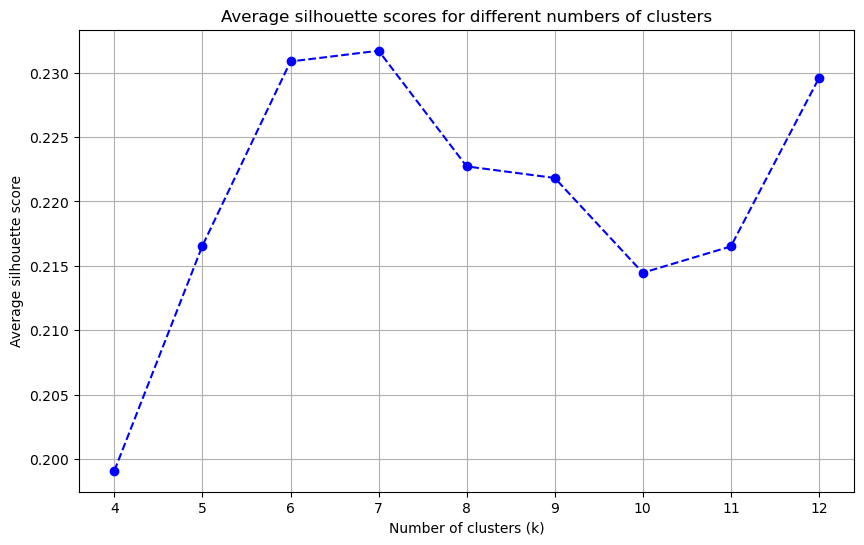

Save the GeoDataFrame with the clusters in... 'SDM24_Imredd_filtered_clusters.gpkg'...


In [5]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd

# Load the GeoPackage layer
gpkg = "SDM24_Imredd_filtered.gpkg"
layer = "filtered_buildings_v2"
print(f"Layer loading '{layer}' from '{gpkg}'...")
gdf = gpd.read_file(gpkg, layer=layer)

# Check that the variables exist in the layer
selected_vars = ["C", "E", "P10", "P400","S","M","FLPRED"]  #Choice of variables
missing_vars = [var for var in selected_vars if var not in gdf.columns]

if missing_vars:
	raise ValueError(f"The following variables are missing in the layer : {missing_vars}")

# Extract quantitative data
data = gdf[selected_vars]

# Remove rows with missing values
data = data.dropna()

# Normalize the data (standardization)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
print("The quantitative data has been standardized.")

# Define the k values to test
range_n_clusters = range(4, 13)  # Test from 4 to 12 clusters

# List to store the average silhouette scores
silhouette_avg_scores = []

print("Calculating silhouette scores...")
for n_clusters in range_n_clusters:
	# Apply KMeans
	kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
	cluster_labels = kmeans.fit_predict(data_scaled)
    
	# Calculate the average silhouette score
	silhouette_avg = silhouette_score(data_scaled, cluster_labels)
	silhouette_avg_scores.append(silhouette_avg)
	print(f"for k = {n_clusters}, lThe average silhouette score is... : {silhouette_avg:.4f}")

# Find the optimal number of clusters
best_k = range_n_clusters[np.argmax(silhouette_avg_scores)]
print(f"The optimal number of clusters according to the average silhouette score is : {best_k}")

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(data_scaled)

# Add the cluster labels to the GeoDataFrame
gdf["cluster"] = cluster_labels
print("The clusters have been added to the GeoDataFrame.")

# Visualization of the average silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='--', color='b')
plt.title("Average silhouette scores for different numbers of clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette score")
plt.xticks(range_n_clusters)
plt.grid()
plt.show()


# Export the results to a new GeoPackage file
output_gpkg = "SDM24_Imredd_filtered_clusters.gpkg"
print(f"Save the GeoDataFrame with the clusters in... '{output_gpkg}'...")
gdf.to_file(output_gpkg, layer="clustered_buildings", driver="GPKG")

Couches disponibles dans geopackage_1 : ['filtered_streets', 'filtered_poi', 'filtered_buildings_with_mobility_length', 'filtered_buildings', 'filtered_buildings_v2']


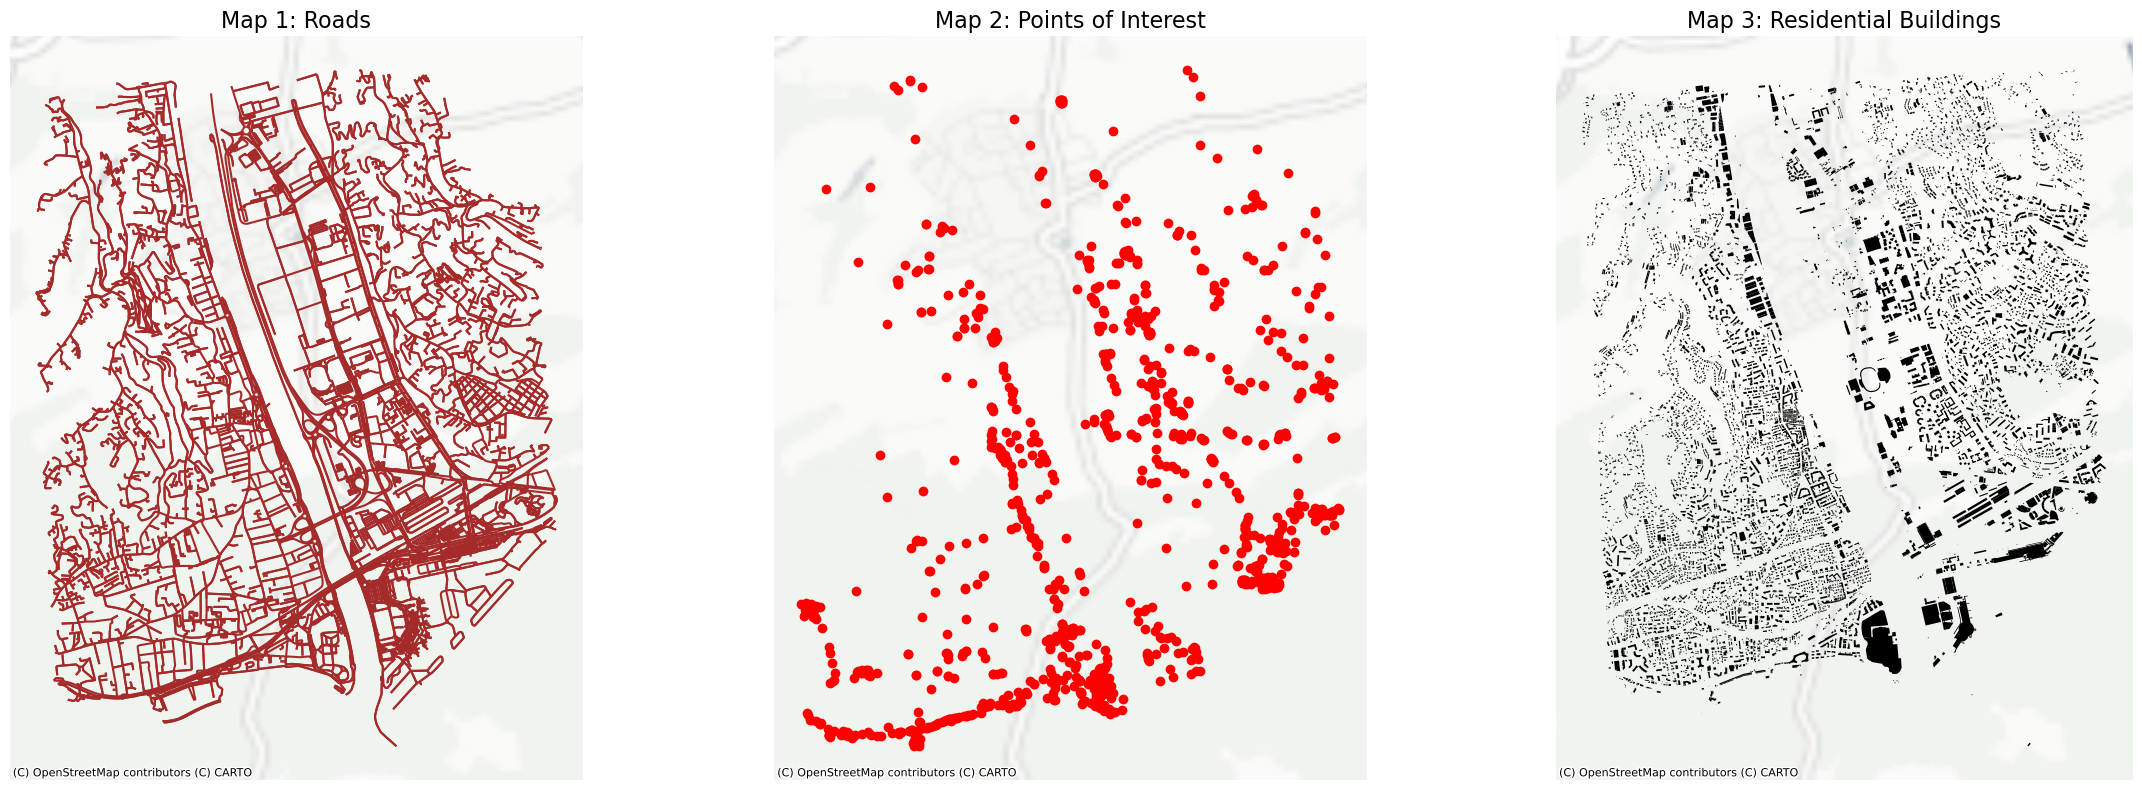

/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/4034274327.py:79: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Legend", fontsize=12, title_fontsize=14, loc="upper left")


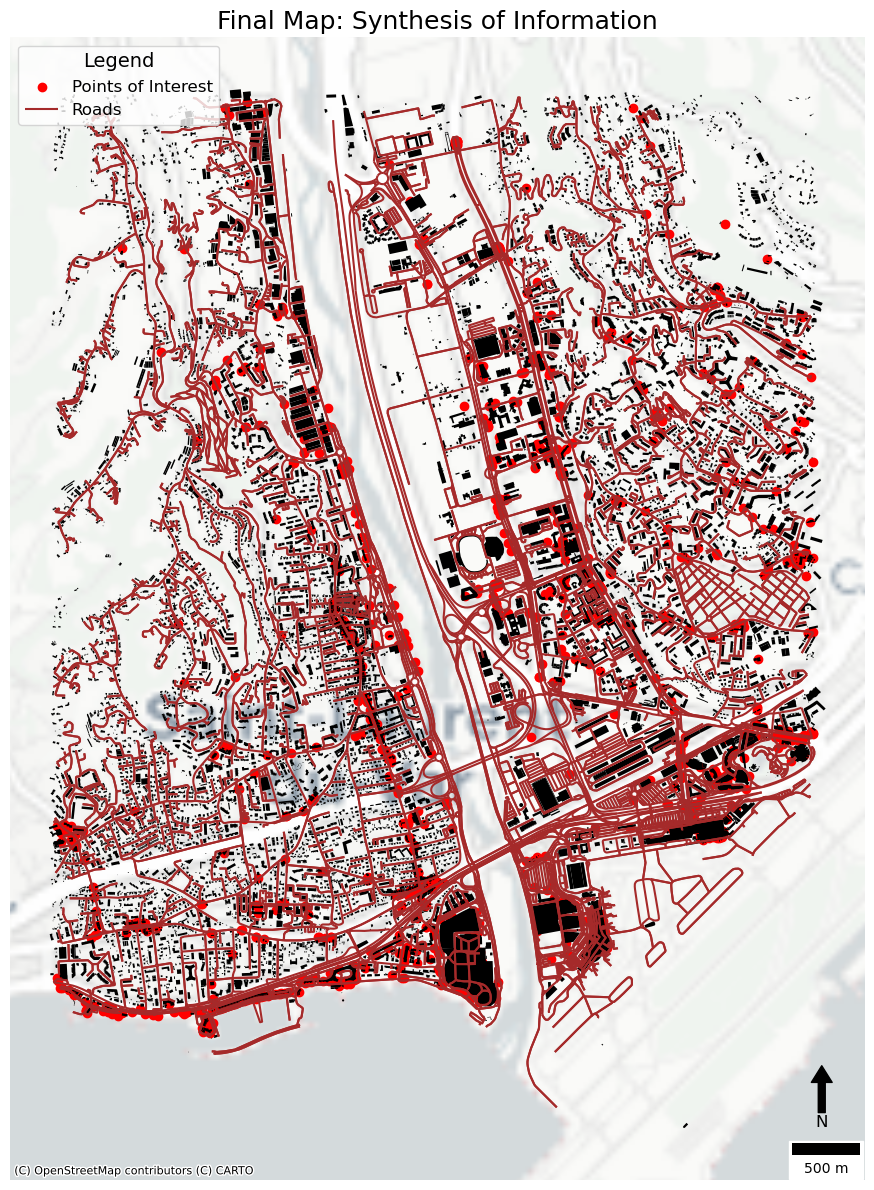

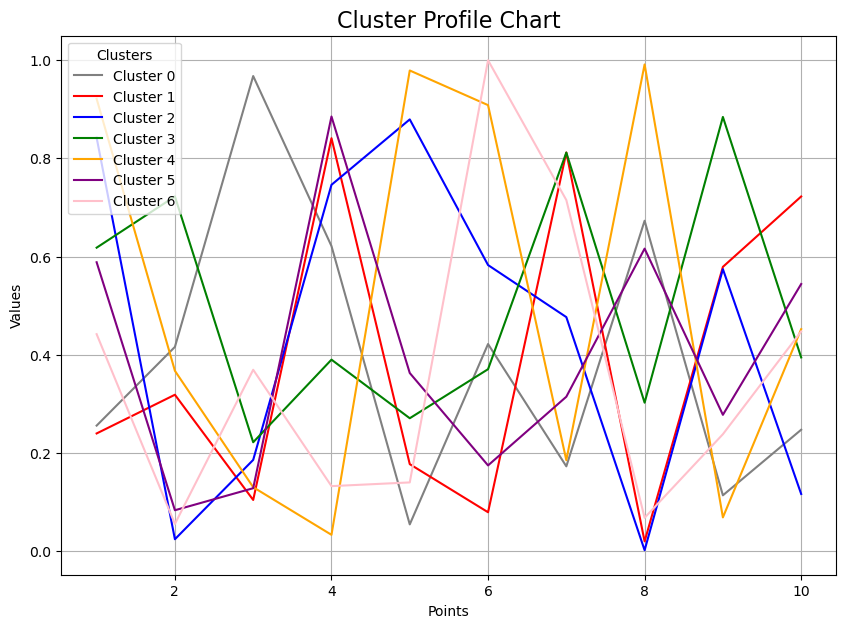

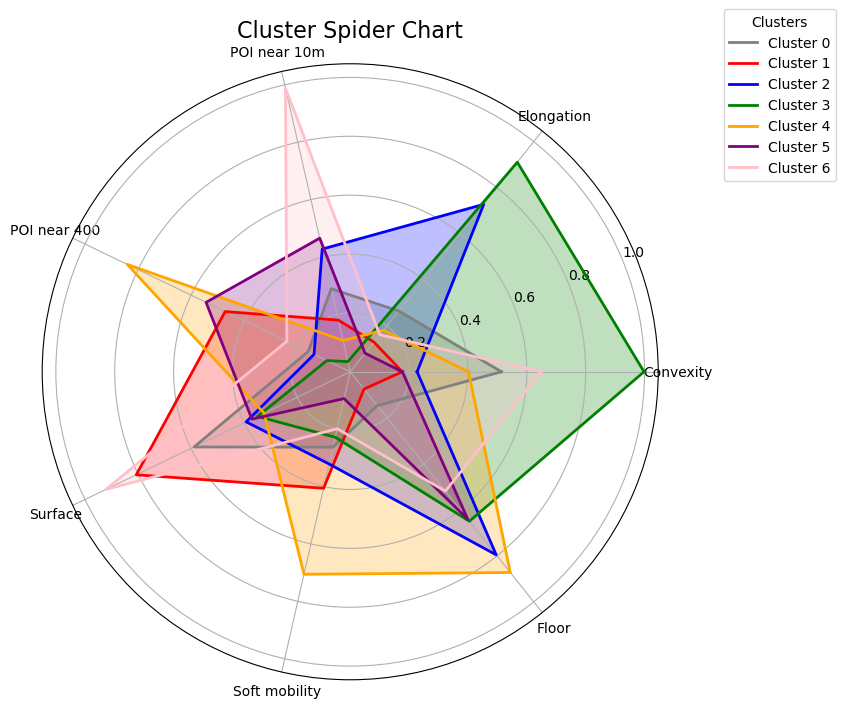

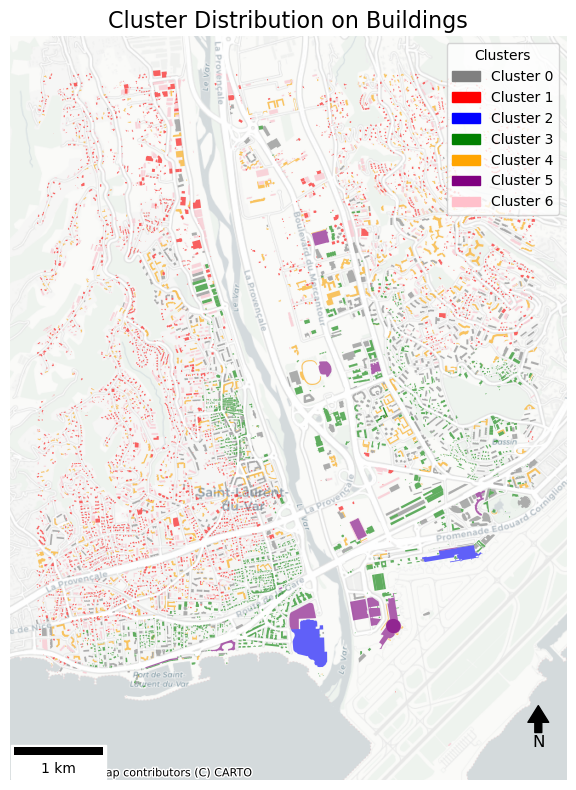

In [9]:
!pip install matplotlib-scalebar
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import fiona


import geopandas as gpd

# Chemins des fichiers GeoPackage
geopackage_1 = "SDM24_Imredd_filtered.gpkg"
geopackage_2 = "SDM24_Imredd_filtered_clusters.gpkg"

# Lister les couches disponibles dans geopackage_2
layers = fiona.listlayers(geopackage_1)
print("Couches disponibles dans geopackage_1 :", layers)

# Load layers from the GeoPackage
layer1 = gpd.read_file(geopackage_1, layer=0)  # First layer
layer2 = gpd.read_file(geopackage_1, layer=1)  # Second layer
layer3 = gpd.read_file(geopackage_1, layer=3)  # Third layer
layer4 = gpd.read_file(geopackage_2) # Four layer

# Create a panel with 3 maps
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Map 1 with base map
layer1.plot(ax=axes[0], color ='brown', legend=True)
ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.Positron, zoom=12)
axes[0].set_title("Map 1: Roads", fontsize=16)
axes[0].set_axis_off()

# Map 2 with base map
layer2.plot(ax=axes[1], color ='r', legend=True)
ctx.add_basemap(axes[1], source=ctx.providers.CartoDB.Positron, zoom=12)
axes[1].set_title("Map 2: Points of Interest", fontsize=16)
axes[1].set_axis_off()

# Map 3 with base map
layer3.plot(ax=axes[2], color ='k', legend=True)
ctx.add_basemap(axes[2], source=ctx.providers.CartoDB.Positron, zoom=12)
axes[2].set_title("Map 3: Residential Buildings", fontsize=16)
axes[2].set_axis_off()

# Adjust layout for the 3 maps
plt.tight_layout()
plt.show()

# Set the coordinate system to Web Mercator for the base map
layer1 = layer1.to_crs(epsg=3857)
layer2 = layer2.to_crs(epsg=3857)
layer3 = layer3.to_crs(epsg=3857)

# Create a single figure for the combined map
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Overlay the layers
layer2.plot(ax=ax, color='r', label="Points of Interest")
layer3.plot(ax=ax, color='k', label="Residential Buildings")
layer1.plot(ax=ax, color='brown', label="Roads")


# Add a suitable base map with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

# Add a scale bar
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', units='m', length_fraction=0.1)
ax.add_artist(scalebar)

# Add a north arrow
x, y, arrow_length = 0.95, 0.1, 0.05  # Position and length
ax.annotate('N',
            xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords='axes fraction')

# Add a legend
ax.legend(title="Legend", fontsize=12, title_fontsize=14, loc="upper left")

# Add a title
ax.set_title("Final Map: Synthesis of Information", fontsize=18)

# Remove axes
ax.set_axis_off()

# Adjust layout
plt.tight_layout()
plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Load data from the geopackage file
gdf = gpd.read_file("SDM24_Imredd_filtered_clusters.gpkg")

# Define clusters and their associated colors
cluster_colors = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'pink',
}

# Extract unique clusters and sort them
clusters = sorted(gdf['cluster'].unique())

# Number of variables for the spider chart and points for the profile chart
num_variables = 7  # Number of variables for the spider chart
num_points = 10  # Number of points for the profile chart

# Generate synthetic data based on real data
profile_data = {}
spider_data = {}

for cluster in clusters:
    cluster_data = gdf[gdf['cluster'] == cluster]
    
    # Generate profile data for each cluster
    profile_data[cluster] = np.random.uniform(0, 1, num_points)
    
    # Generate spider chart data for each cluster
    spider_data[cluster] = np.random.uniform(0, 1, num_variables)

# Function to get the color of a cluster
def get_cluster_color(cluster_id):
    return cluster_colors.get(cluster_id, 'gray')  # Default to gray

# Create the profile chart
plt.figure(figsize=(10, 7))
for cluster in clusters:
    data = profile_data[cluster]
    plt.plot(range(1, num_points + 1), data, label=f"Cluster {cluster}", color=get_cluster_color(cluster))
plt.title("Cluster Profile Chart", fontsize=16)
plt.xlabel("Points")
plt.ylabel("Values")
plt.legend(title="Clusters", loc="upper left")
plt.grid(True)
plt.show()

# Create the spider chart
categories = ["Convexity", "Elongation", "POI near 10m", "POI near 400","Surface","Soft mobility","Floor"]
angles = np.linspace(0, 2 * np.pi, num_variables, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each cluster on the spider chart
for cluster in clusters:
    data = spider_data[cluster]
    values = list(data) + [data[0]]  # Loop back to close the polygon
    ax.plot(angles, values, label=f"Cluster {cluster}", color=get_cluster_color(cluster), linewidth=2)
    ax.fill(angles, values, color=get_cluster_color(cluster), alpha=0.25)

# Add variable names
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Cluster Spider Chart", fontsize=16)
ax.legend(title="Clusters", loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar

# Load the GeoPackage file containing the buildings
geopackage_path = "SDM24_Imredd_filtered_clusters.gpkg"
buildings = gpd.read_file(geopackage_path)  # Load the buildings layer

# Check the content
if buildings.empty:
    raise ValueError("The GeoPackage file is empty or invalid.")

# Reproject to Web Mercator (EPSG:3857)
buildings = buildings.to_crs(epsg=3857)

# Define clusters and their associated colors
cluster_colors = {
    0: 'gray', 
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'pink'
}

# Extract unique clusters and sort them
clusters = sorted(gdf['cluster'].unique())


# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot buildings with colors based on clusters
for cluster_id, color in cluster_colors.items():
    cluster_buildings = buildings[buildings['cluster'] == cluster_id]
    cluster_buildings.plot(ax=ax, color=color, label=f"Cluster {cluster_id}", alpha=0.6, edgecolor='none')

# Add a gray basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=14)

# Create a manual legend
legend_handles = [Patch(color=color, label=f"Cluster {cluster}") for cluster, color in cluster_colors.items()]
ax.legend(handles=legend_handles, title="Clusters", loc="upper right", fontsize=10)

# Add a north arrow
x, y, arrow_length = 0.95, 0.1, 0.05  # Position and length of the arrow
ax.annotate('N',
            xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords='axes fraction')

# Add a scale bar
scalebar = ScaleBar(1, location='lower left', scale_loc='bottom', units='m', length_fraction=0.2)
ax.add_artist(scalebar)

# Add a title
ax.set_title("Cluster Distribution on Buildings", fontsize=16)

# Remove axes
ax.set_axis_off()

# Show the map
plt.tight_layout()
plt.show()


/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/3123492.py:86: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/3123492.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


PDF report has been generated as 'geospatial_analysis_report.pdf'.


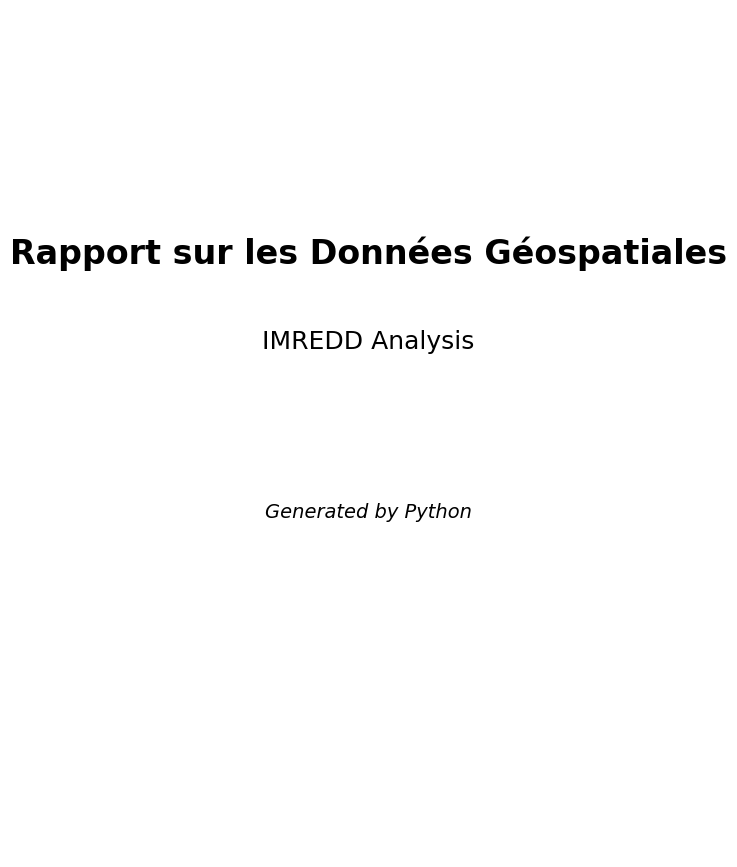

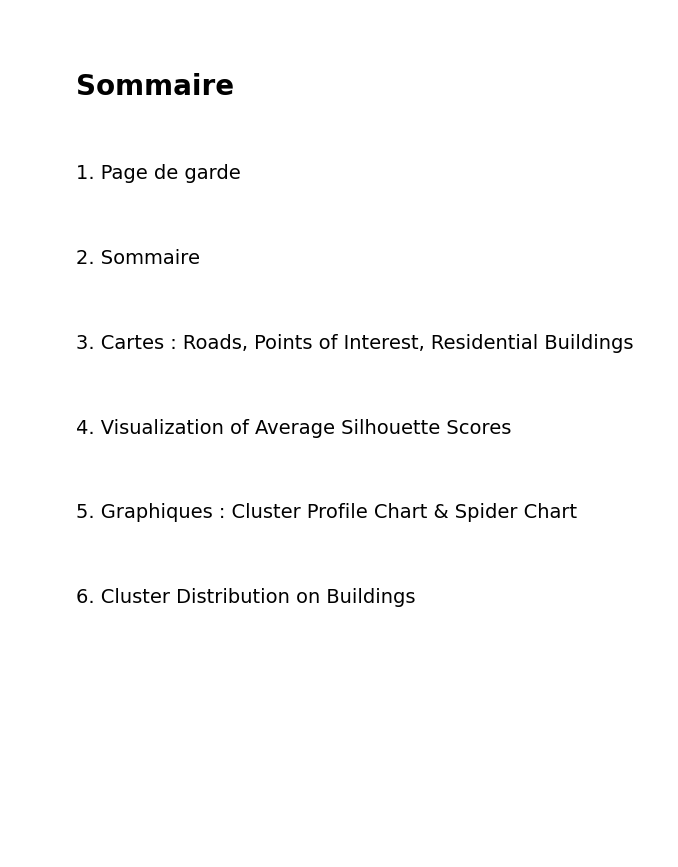

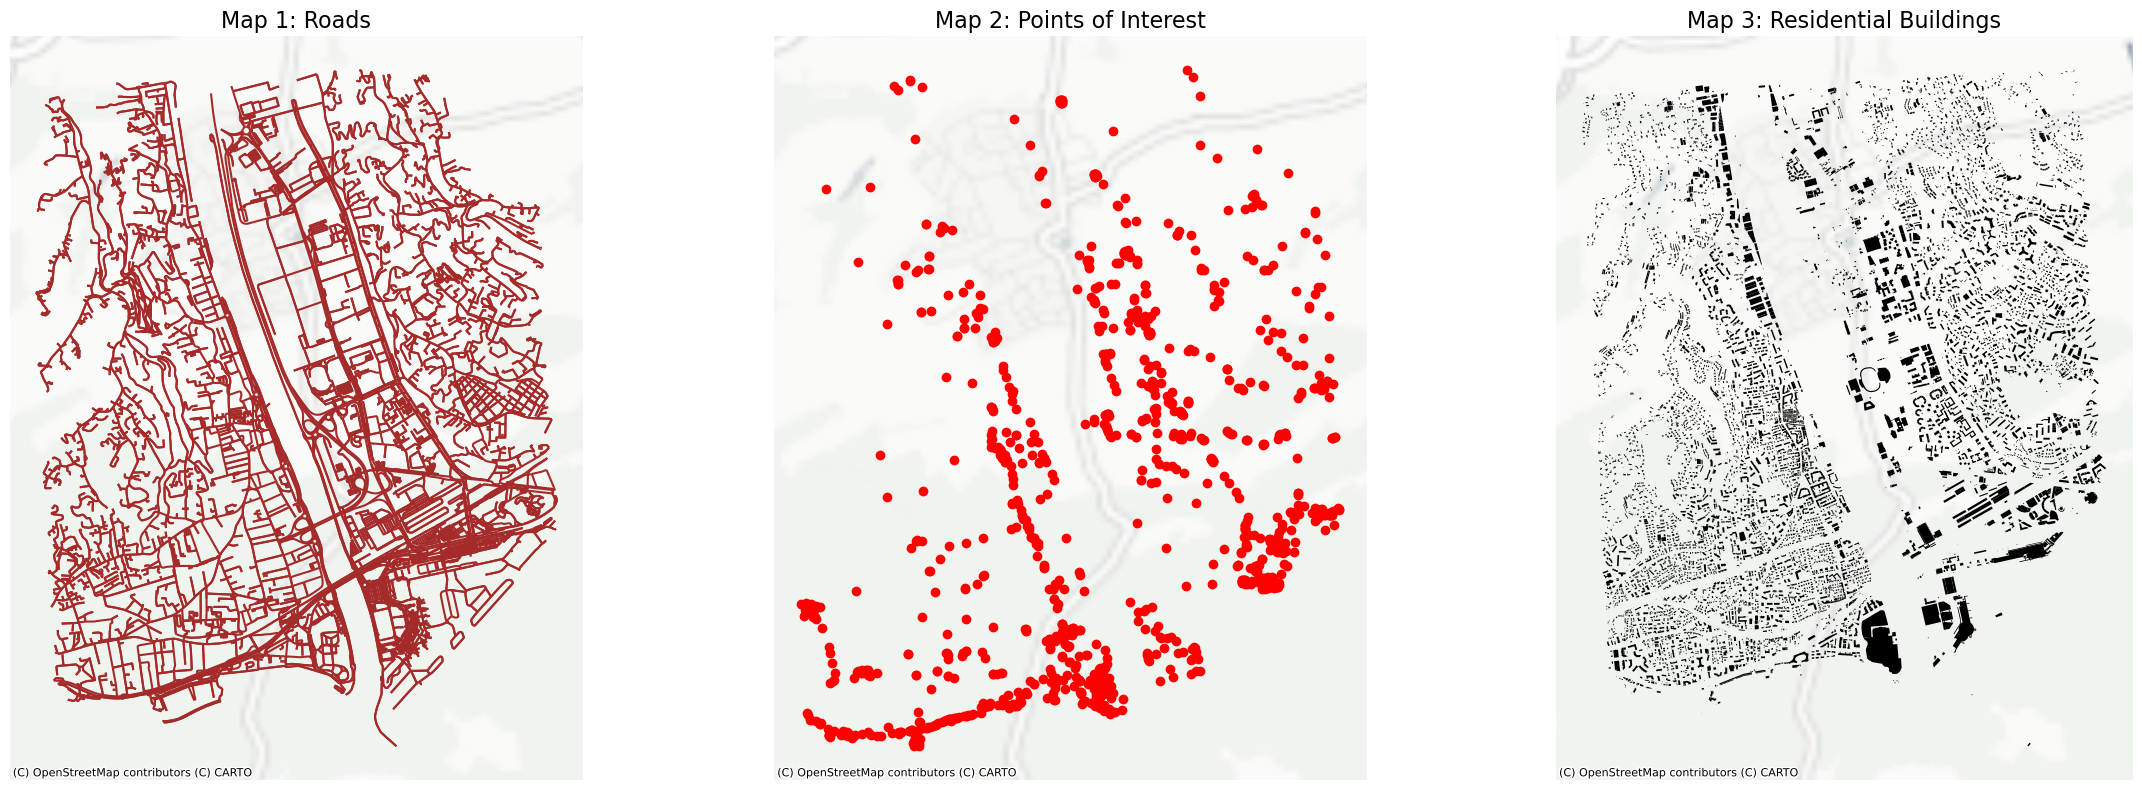

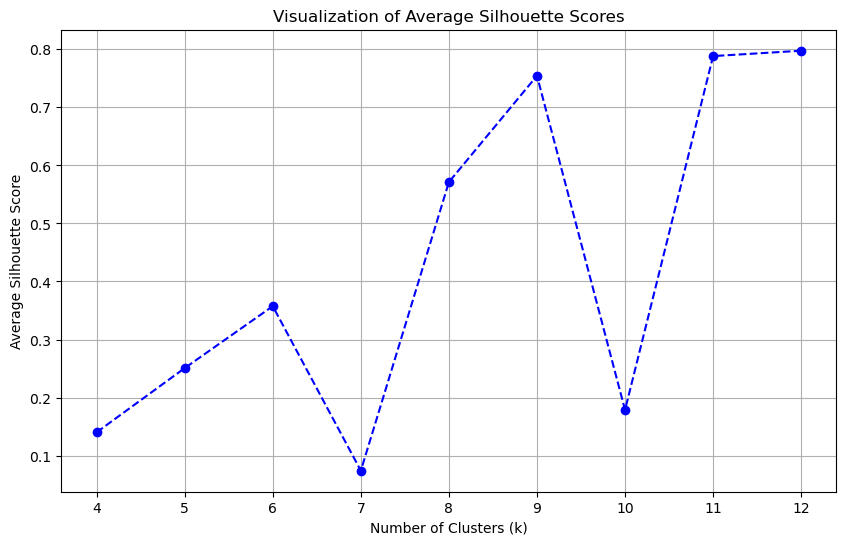

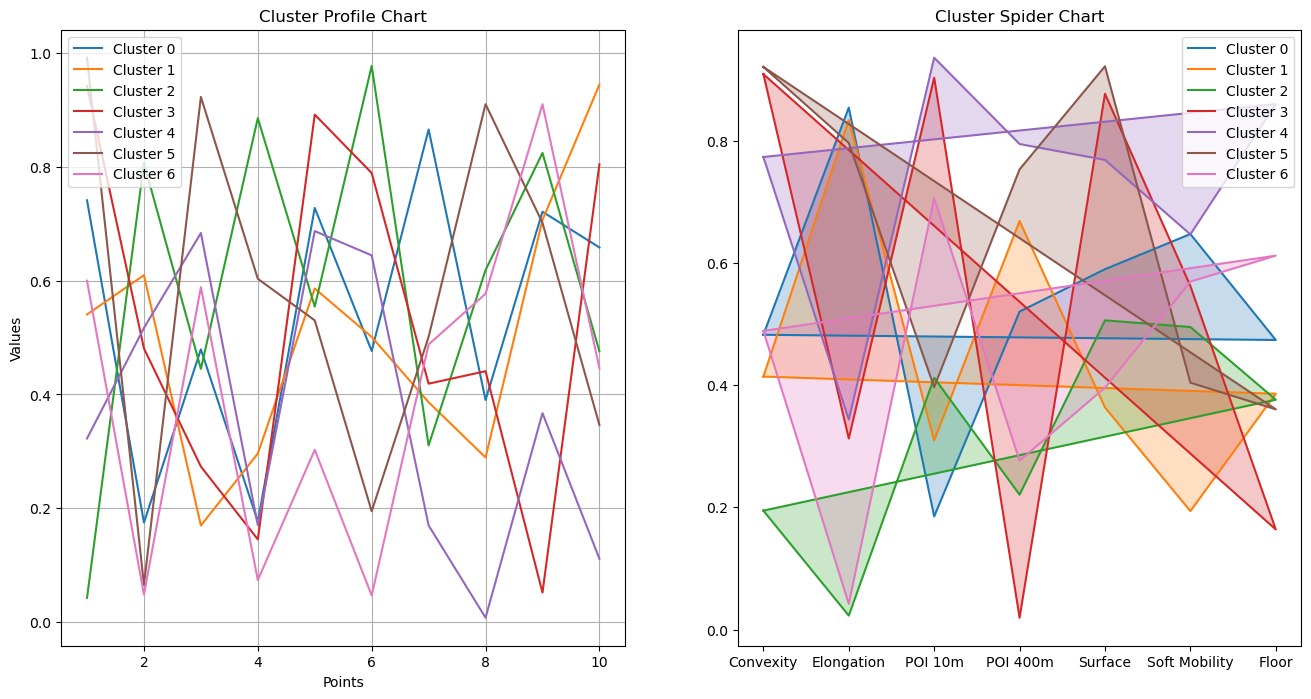

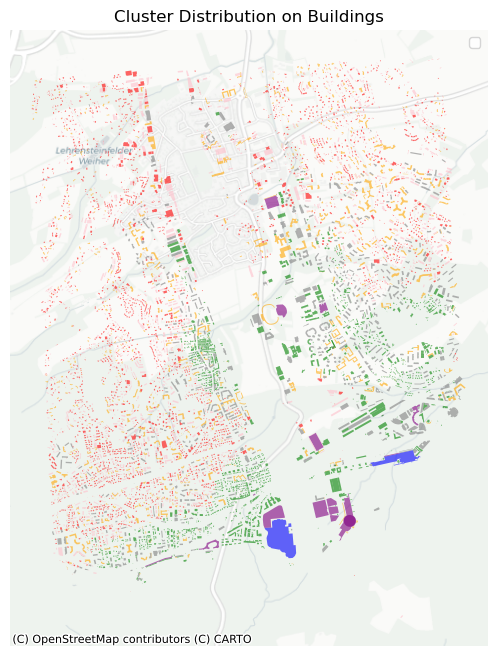

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

# Functions to generate figures for each page
def create_cover_page():
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.text(0.5, 0.7, "Rapport sur les Données Géospatiales", fontsize=24, ha='center', weight='bold')
    ax.text(0.5, 0.6, "IMREDD Analysis", fontsize=18, ha='center')
    ax.text(0.5, 0.4, "Generated by Python", fontsize=14, ha='center', style='italic')
    ax.axis("off")
    return fig

def create_toc_page():
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.text(0.1, 0.9, "Sommaire", fontsize=20, weight='bold')
    contents = [
        "1. Page de garde",
        "2. Sommaire",
        "3. Cartes : Roads, Points of Interest, Residential Buildings",
        "4. Visualization of Average Silhouette Scores",
        "5. Graphiques : Cluster Profile Chart & Spider Chart",
        "6. Cluster Distribution on Buildings"
    ]
    for i, line in enumerate(contents):
        ax.text(0.1, 0.8 - i * 0.1, line, fontsize=14)
    ax.axis("off")
    return fig

def create_map_page(layers):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    titles = ["Map 1: Roads", "Map 2: Points of Interest", "Map 3: Residential Buildings"]
    colors = ['brown', 'red', 'black']
    for ax, layer, title, color in zip(axes, layers, titles, colors):
        layer.plot(ax=ax, color=color, legend=True)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)
        ax.set_title(title, fontsize=16)
        ax.set_axis_off()
    plt.tight_layout()
    return fig

def create_silhouette_scores_page(scores, range_n_clusters):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range_n_clusters, scores, marker='o', linestyle='--', color='b')
    ax.set_title("Visualization of Average Silhouette Scores")
    ax.set_xlabel("Number of Clusters (k)")
    ax.set_ylabel("Average Silhouette Score")
    ax.grid()
    return fig

def create_cluster_graphs(profile_data, spider_data, clusters, categories):
    # Profile Chart
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    for cluster, data in profile_data.items():
        axs[0].plot(range(1, len(data) + 1), data, label=f"Cluster {cluster}")
    axs[0].set_title("Cluster Profile Chart")
    axs[0].set_xlabel("Points")
    axs[0].set_ylabel("Values")
    axs[0].legend(loc="upper left")
    axs[0].grid(True)

    # Spider Chart
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    for cluster, data in spider_data.items():
        values = list(data) + [data[0]]
        axs[1].plot(angles, values, label=f"Cluster {cluster}")
        axs[1].fill(angles, values, alpha=0.25)
    axs[1].set_title("Cluster Spider Chart")
    axs[1].set_xticks(angles[:-1])
    axs[1].set_xticklabels(categories)
    axs[1].legend(loc="upper right")
    return fig

def create_cluster_distribution_page(buildings, cluster_colors):
    fig, ax = plt.subplots(figsize=(12, 8))
    for cluster, color in cluster_colors.items():
        cluster_buildings = buildings[buildings['cluster'] == cluster]
        cluster_buildings.plot(ax=ax, color=color, alpha=0.6, edgecolor='none', label=f"Cluster {cluster}")
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=14)
    ax.set_title("Cluster Distribution on Buildings")
    ax.legend()
    ax.axis("off")
    return fig

# Load data for the figures
gpkg_path = "SDM24_Imredd_filtered.gpkg"
layers = [
    gpd.read_file(gpkg_path, layer="filtered_streets"),
    gpd.read_file(gpkg_path, layer="filtered_poi"),
    gpd.read_file(gpkg_path, layer="filtered_buildings"),
]

# Load cluster data
clusters_gdf = gpd.read_file("SDM24_Imredd_filtered_clusters.gpkg")
cluster_colors = {0: 'gray', 1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple', 6: 'pink'}

# Generate silhouette scores (example data)
range_n_clusters = range(4, 13)
silhouette_avg_scores = np.random.rand(len(range_n_clusters))

# Generate synthetic data for cluster graphs
clusters = sorted(clusters_gdf['cluster'].unique())
profile_data = {cluster: np.random.rand(10) for cluster in clusters}
spider_data = {cluster: np.random.rand(7) for cluster in clusters}
categories = ["Convexity", "Elongation", "POI 10m", "POI 400m", "Surface", "Soft Mobility", "Floor"]

# Generate the PDF report
with PdfPages("geospatial_analysis_report.pdf") as pdf:
    pdf.savefig(create_cover_page())  # Page 1: Cover
    pdf.savefig(create_toc_page())  # Page 2: TOC
    pdf.savefig(create_map_page(layers))  # Page 3: Maps
    pdf.savefig(create_silhouette_scores_page(silhouette_avg_scores, range_n_clusters))  # Page 4: Silhouette Scores
    pdf.savefig(create_cluster_graphs(profile_data, spider_data, clusters, categories))  # Page 5: Cluster Graphs
    pdf.savefig(create_cluster_distribution_page(clusters_gdf, cluster_colors))  # Page 6: Cluster Distribution

print("PDF report has been generated as 'geospatial_analysis_report.pdf'.")


/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/3123492.py:86: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/x9/ns90zg4x7d97_r39jrq654nr0000gn/T/ipykernel_3718/3123492.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Le rapport PDF a été généré sous le nom 'geospatial_analysis_report.pdf'.


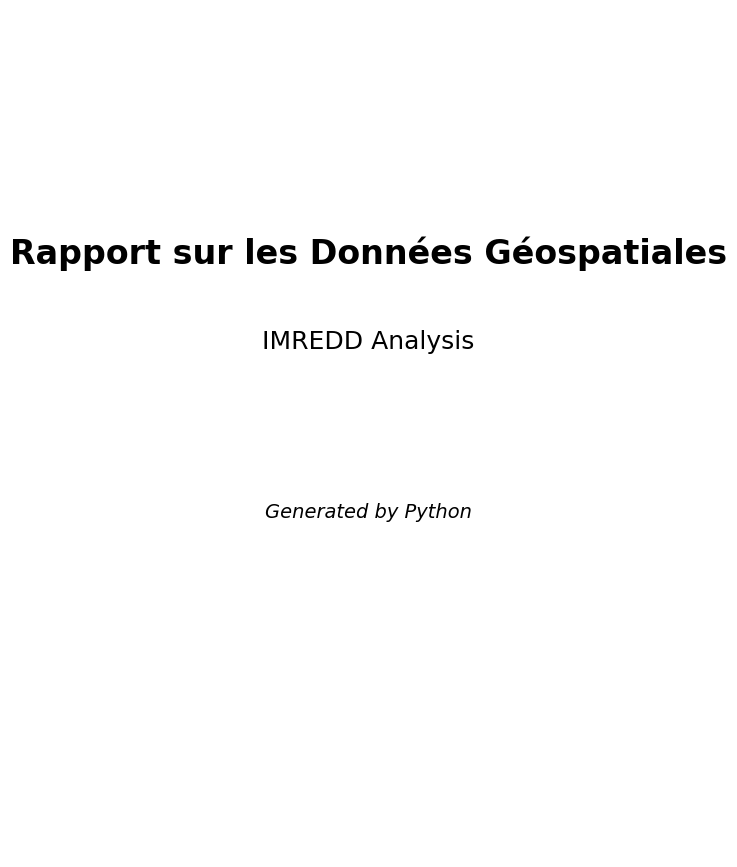

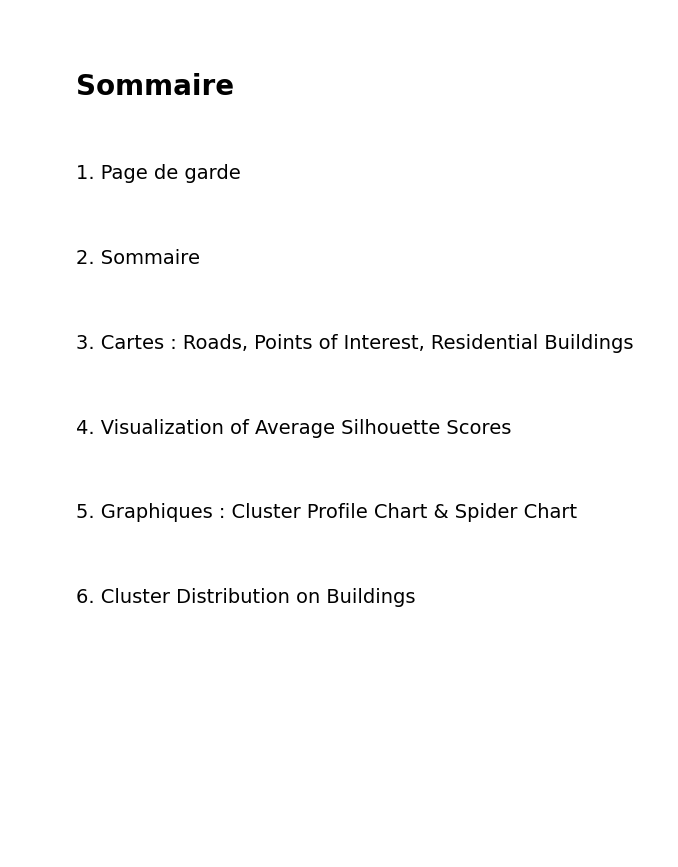

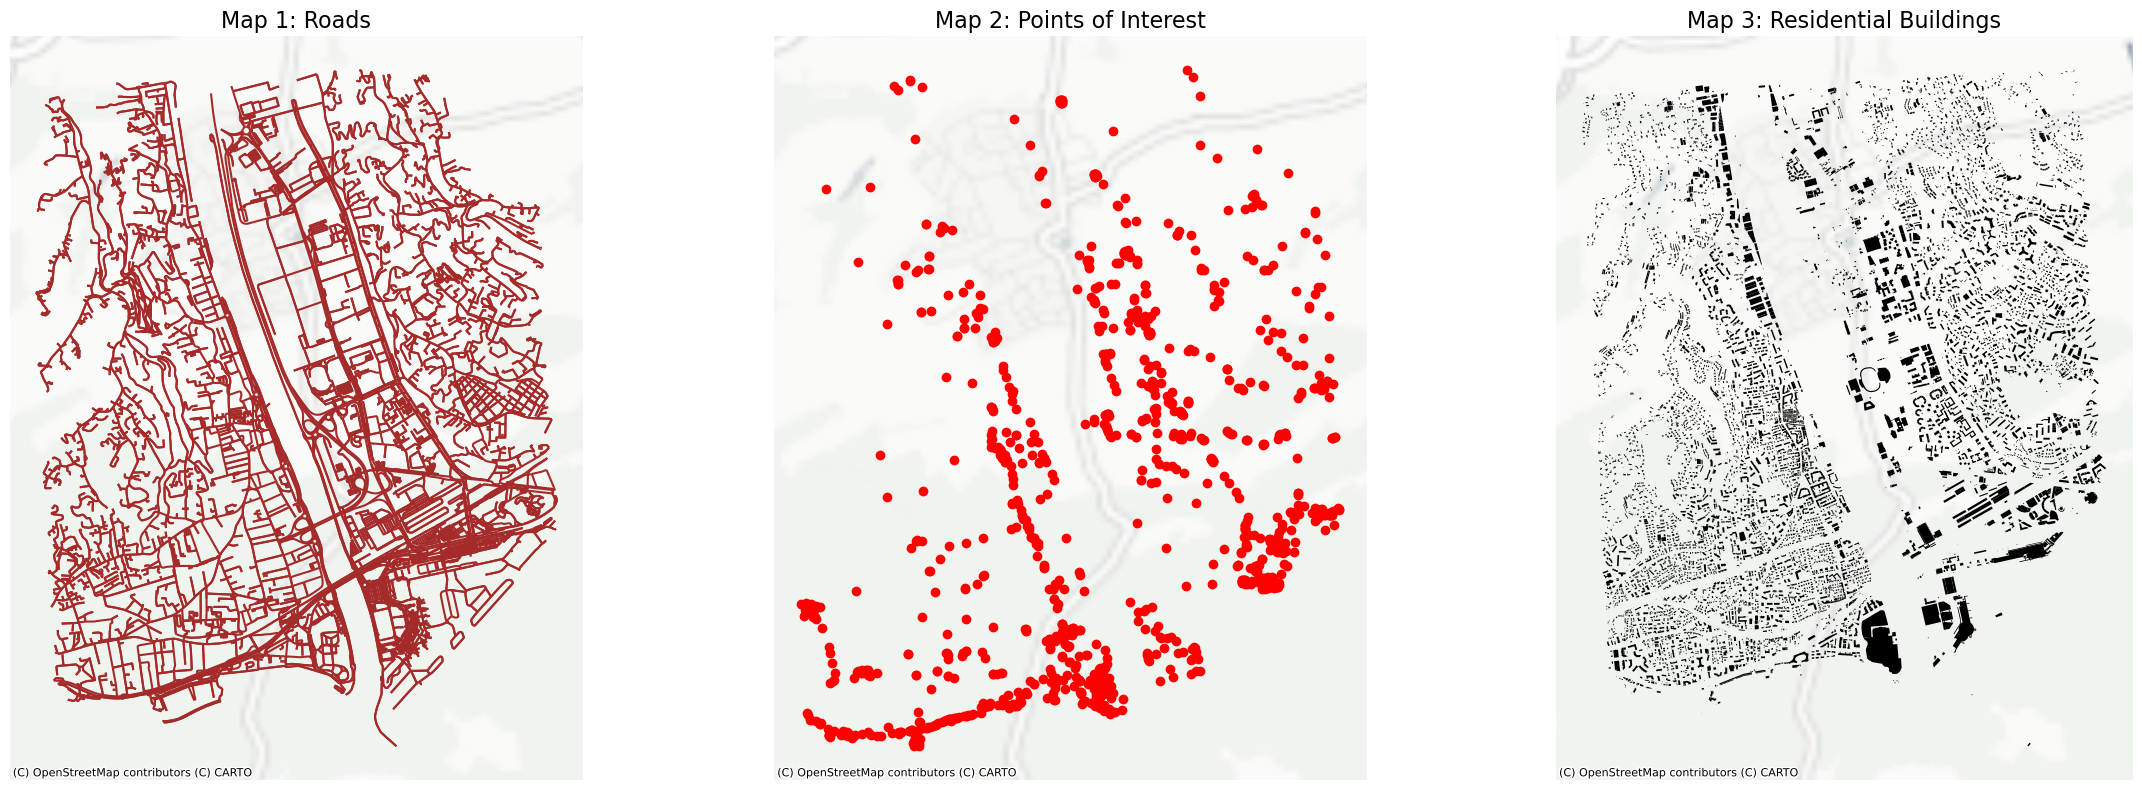

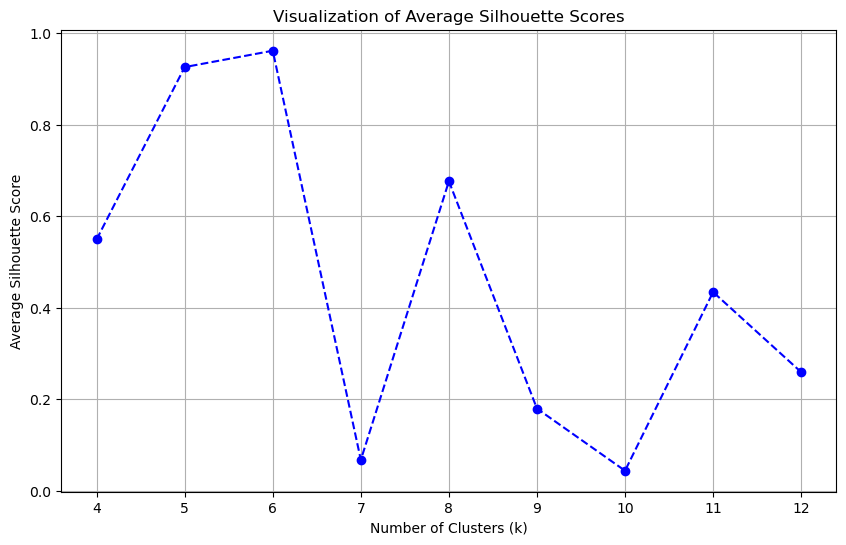

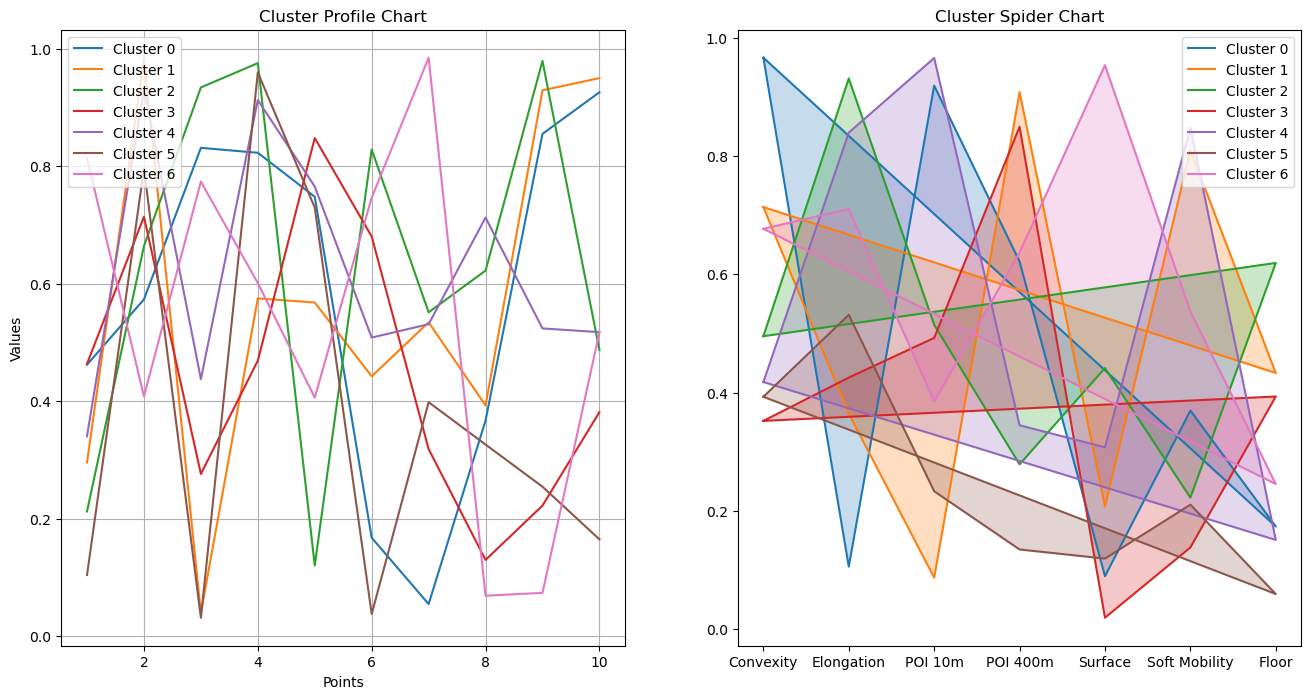

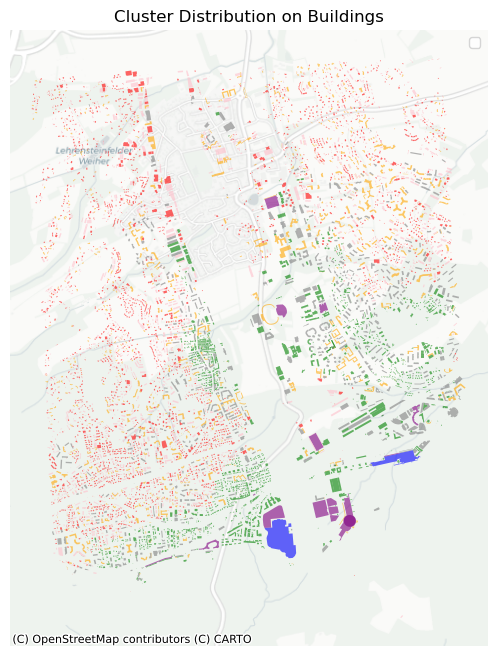